In [1]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

print(list(newsgroups_train.target_names))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


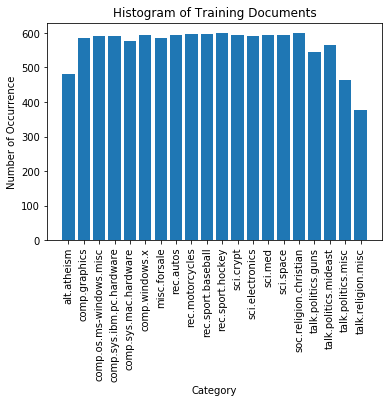

In [2]:
import matplotlib.pyplot as plt
import numpy as np

category, total = np.unique(newsgroups_train.target, return_counts=True)
plt.bar(category,total, tick_label=newsgroups_train.target_names)
plt.title('Histogram of Training Documents')
plt.xlabel('Category')
plt.ylabel('Number of Occurrence')
plt.xticks(rotation='vertical')
plt.show()


In [3]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
train_dataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 42)
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = 42)

In [4]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string
import re
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

#POS TAG CODE TAKEN FROM HERE https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def custom_tokenizer(string_of_text):
    tokens = nltk.word_tokenize(string_of_text)
    tokens = [lemmatizer.lemmatize(text, get_wordnet_pos(text)) for text in tokens if not re.match(r'^-?\d+(?:\.\d+)?$', text)]
    #tokens = [lemmatizer.lemmatize(text, get_wordnet_pos(text)) for text in tokens]
    return tokens

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\macro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\macro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\macro\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

CV = CountVectorizer(min_df = 3, stop_words = 'english', tokenizer = custom_tokenizer)

getCVTrain = CV.fit_transform(train_dataset.data)
getCVTest = CV.transform(test_dataset.data)


D:\Anaconda3\envs\EE219\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make', 'u'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [6]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfTransform = TfidfTransformer()

trainTfidf = tfidfTransform.fit_transform(getCVTrain)
testTfidf = tfidfTransform.transform(getCVTest)

print(trainTfidf.shape)
print(testTfidf.shape)

(4732, 18488)
(3150, 18488)


In [7]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50)
getLSITrain = svd.fit_transform(trainTfidf)
getLSITest = svd.transform(testTfidf)

print(getLSITrain.shape)
print(np.sum(getLSITrain**2))
print(getLSITest.shape)
print(np.sum(getLSITest**2))

(4732, 50)
1403.9830149958018
(3150, 50)
896.5609705442956


In [12]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=50)
getNMFTrain = nmf.fit_transform(trainTfidf)
getNMFTest = nmf.transform(testTfidf)

print(np.sum(np.array(trainTfidf - svd.inverse_transform(getLSITrain))**2))
print(np.sum(np.array(trainTfidf - getNMFTrain.dot(nmf.components_))**2))

3328.0169850041893
3360.569169229194


In [11]:
label_train = []
label_test = []

for i in range(len(train_dataset.data)):
    if 'comp' in train_dataset.filenames[i]:
        label_train.append(0)
    else:
        label_train.append(1)
        
for i in range(len(test_dataset.data)):
    if 'comp' in test_dataset.filenames[i]:
        label_test.append(0)
    else:
        label_test.append(1)
        

Precision: 0.9404690318701142
Recall: 0.9836477987421384
F1: 0.9615739317553028


D:\Anaconda3\envs\EE219\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


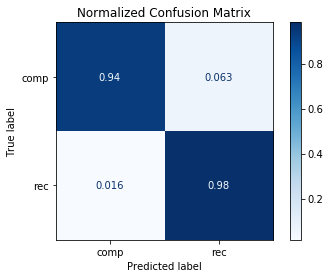

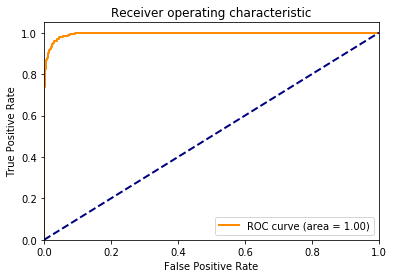

In [18]:
from sklearn.svm import LinearSVC
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

svmHard = LinearSVC(C=1000)
svmHard.fit(getLSITrain, label_train)
score = svmHard.decision_function(getLSITest)
predicted = svmHard.predict(getLSITest)


print('Precision:', metrics.precision_score(label_test, predicted))
print('Recall:', metrics.recall_score(label_test, predicted))
print('F1:', metrics.f1_score(label_test, predicted))
disp = plot_confusion_matrix(svmHard, getLSITest, label_test,
                                 display_labels=['comp','rec'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Normalized Confusion Matrix')

fpr, tpr, _ = metrics.roc_curve(label_test, score)
roc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Precision: 0.6041181041181041
Recall: 0.9779874213836478
F1: 0.7468780019212296


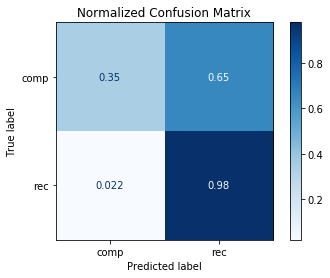

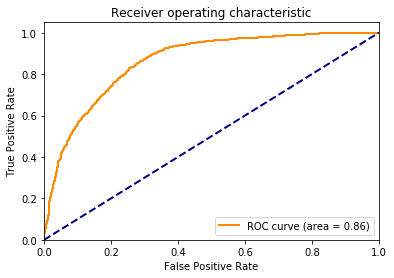

In [21]:
svmSoft = LinearSVC(C=0.0001)
svmSoft.fit(getLSITrain, label_train)
score = svmSoft.decision_function(getLSITest)
predicted = svmSoft.predict(getLSITest)


print('Precision:', metrics.precision_score(label_test, predicted))
print('Recall:', metrics.recall_score(label_test, predicted))
print('F1:', metrics.f1_score(label_test, predicted))
disp = plot_confusion_matrix(svmSoft, getLSITest, label_test,
                                 display_labels=['comp','rec'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Normalized Confusion Matrix')

fpr, tpr, _ = metrics.roc_curve(label_test, score)
roc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()